<a href="https://colab.research.google.com/github/patrickabadi/python-pytorch-notebooks/blob/main/01_pytorch_workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
what_were_covering = {
    1: "data (prepare and load)",
    2: "build model",
    3: "fitting the model to data (training)",
    4: "making predictions and evaluating a model (inference)",
    5: "saving and loading a model",
    6: "putting it all together"
}

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

torch.__version__


'1.13.1+cu116'

## Preparing and loading data

In [ ]:
# known parameters
weight = 0.7
bias = 0.3

# create
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight*X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]), tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

### splitting data into training and test sets

In [ ]:
# create train/test split
train_split = int(0.8*len(X))

X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)


(40, 40, 10, 10)

In [ ]:
def plot_predictions(train_data=X_train, 
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions = None):
  plt.figure(figsize=(10,7))

  plt.scatter(train_data, train_labels, c="b", s=4, label="training_data")

  plt.scatter(test_data, test_labels, c="g", s=4, label="testing data")

  if predictions is not None:
    plt.scatter(test_data, predictions, c="r", s=4, label = "predictions")

  plt.legend(prop={"size": 14})

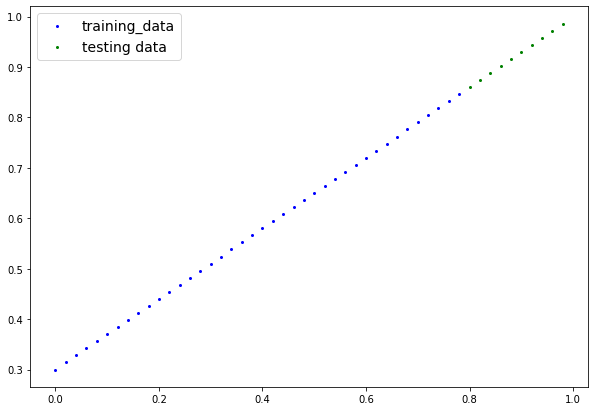

In [ ]:
plot_predictions();

## our first pytorch model

In [ ]:
class LinearRegressionModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1, 
                                            requires_grad=True,
                                            dtype = torch.float))
    self.bias = nn.Parameter(torch.rand(1, 
                                            requires_grad=True,
                                            dtype = torch.float))
    
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.weights * x + self.bias

    

In [ ]:
# create a random seed
torch.manual_seed(42)

model_0 = LinearRegressionModel()

list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True), Parameter containing:
 tensor([0.3904], requires_grad=True)]

In [ ]:
with torch.inference_mode():
  y_preds = model_0(X_test)

y_preds

tensor([[0.6598],
        [0.6665],
        [0.6733],
        [0.6800],
        [0.6867],
        [0.6935],
        [0.7002],
        [0.7069],
        [0.7137],
        [0.7204]])

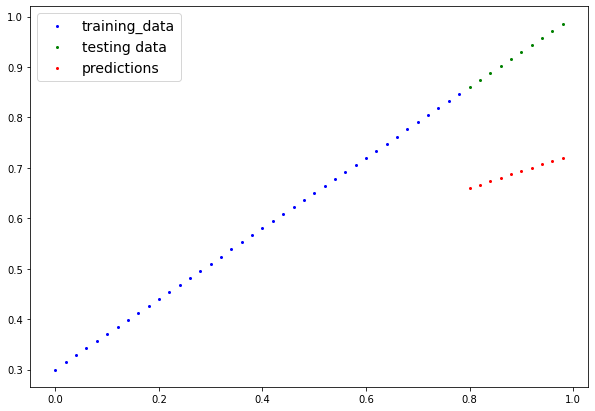

In [ ]:
plot_predictions(predictions=y_preds)

In [ ]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True), Parameter containing:
 tensor([0.3904], requires_grad=True)]

## training the model

In [ ]:
# setup a loss function
loss_fn = nn.L1Loss()

# setup the optimizer
optimizer = torch.optim.SGD(params = model_0.parameters(),
                            lr=0.01)

### building a training loop (and testing loop) in PyTorch

In [ ]:
epochs = 2000

# track different values
epoch_count = []
loss_values = []
test_loss_values = []

for epoch in range(epochs):
  model_0.train() # train mode sets all parameters that require gradients

  # 1.forward pass
  y_pred = model_0(X_train)

  # 2.calc loss
  loss = loss_fn(y_pred, y_train)
  #print(f"loss {loss}")

  # 3.optimizer - zero out the gradient
  optimizer.zero_grad()

  # 4. perform backpropogation on the loss with respect to the parameters of the model
  loss.backward()

  # 5. step the optimizer (perform gradient descent)
  optimizer.step()

  model_0.eval() # turns off gradient tracking
  with torch.inference_mode():
    test_pred = model_0(X_test)

    test_loss = loss_fn(test_pred, y_test)

  if epoch %10 == 0:
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)
    print(f"Epoch: {epoch} | Test: {loss} | Test loss {test_loss}")
    print(model_0.state_dict())

Epoch: 0 | Test: 0.08169572055339813 | Test loss 0.22662055492401123
OrderedDict([('weights', tensor([0.3398])), ('bias', tensor([0.3939]))])
Epoch: 10 | Test: 0.06808149069547653 | Test loss 0.1807345449924469
OrderedDict([('weights', tensor([0.3672])), ('bias', tensor([0.4154]))])
Epoch: 20 | Test: 0.06258393079042435 | Test loss 0.15627031028270721
OrderedDict([('weights', tensor([0.3891])), ('bias', tensor([0.4204]))])
Epoch: 30 | Test: 0.05879194289445877 | Test loss 0.1418602615594864
OrderedDict([('weights', tensor([0.4081])), ('bias', tensor([0.4179]))])
Epoch: 40 | Test: 0.05530194193124771 | Test loss 0.13084018230438232
OrderedDict([('weights', tensor([0.4261])), ('bias', tensor([0.4129]))])
Epoch: 50 | Test: 0.051822252571582794 | Test loss 0.12050700187683105
OrderedDict([('weights', tensor([0.4439])), ('bias', tensor([0.4074]))])
Epoch: 60 | Test: 0.04838593676686287 | Test loss 0.11223447322845459
OrderedDict([('weights', tensor([0.4610])), ('bias', tensor([0.4004]))])
E

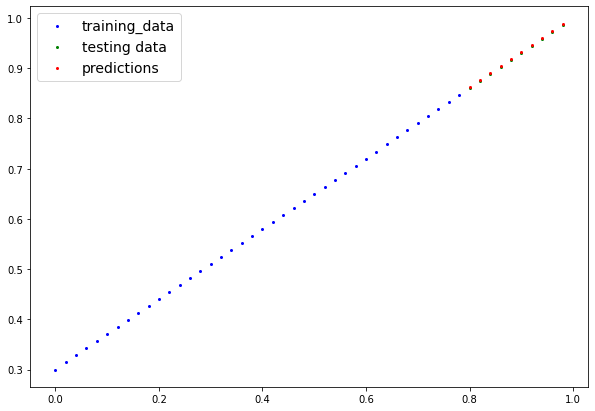

In [ ]:
with torch.inference_mode():
  y_preds_new = model_0(X_test)
  

plot_predictions(predictions=y_preds_new)

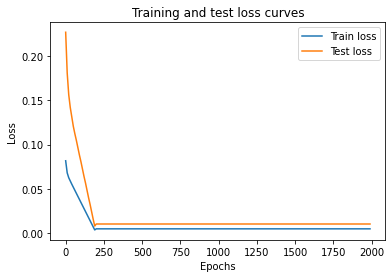

In [ ]:
import numpy as np
plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label="Train loss")
plt.plot(epoch_count, test_loss_values, label = "Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

### Saving a model in PyTorch


In [ ]:
from pathlib import Path

# 1. create model directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents = True, exist_ok=True)

# 2. create model save path
MODEL_NAME= "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save model state_dict
print(f"Saving model to {MODEL_SAVE_PATH}")
torch.save(model_0.state_dict(), MODEL_SAVE_PATH)

Saving model to models/01_pytorch_workflow_model_0.pth


### Loading a Pytorch model

In [ ]:
loaded_model_0 = LinearRegressionModel()

loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.6962])), ('bias', tensor([0.3064]))])

In [ ]:
loaded_model_0.eval()
with torch.inference_mode():
  loaded_model_preds = loaded_model_0(X_test)

  y_preds == loaded_model_preds